In [1]:
import gymnasium as gym
import numpy as np
from IPython.display import display, clear_output, Image
import time
# from PIL import Image
from collections import deque
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
env = gym.make('LunarLander-v3', render_mode='human')  

In [3]:
env.unwrapped.render_mode = 'human'

state, info = env.reset()
for step in range(1000):
    action = env.action_space.sample()
    state, reward, done, truncated, info = env.step(action)
    
    clear_output(wait=True)
    print('taking action', action, ' got reward', reward)

    if done or truncated:
        print(f"Episode finished with environment reward: {reward}")
        break

taking action 3  got reward -100
Episode finished with environment reward: -100


In [4]:
print(env.action_space)
print(env.observation_space.shape)

Discrete(4)
(8,)


# DDQN with soft updates to target network

In [5]:
class QNetwork(nn.Module):
    def __init__(self, n_in, n_out):
        super().__init__()
        self.fc1 = nn.Linear(n_in, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, n_out)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ReplayBuffer:
    def __init__(self, maxlen):
        self.buffer = deque(maxlen=maxlen)

    def __len__(self): 
        return len(self.buffer)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        assert batch_size <= len(self), 'sample size is greater than population of buffer'
        states, actions, rewards, next_states, dones = zip(*random.sample(self.buffer, batch_size))  # with replacement
        # converting to ndarray then to tensor is probably faster than directly to tensor
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)  


In [16]:
class Agent:
    def __init__(self, env, state):
        self.env = env
        self.state = state
        self.action_d = self.env.action_space.n
        self.state_d = self.env.observation_space.shape[0]
        
        self.gamma = 0.99
        self.learn_freq = 4
        self.sync_freq = 4
        self.tau = 0.001  # percentage of 'new' parameters in soft updates
        self.batch_size = 64
        
        self.memory = ReplayBuffer(100_000)
        self.start_samples = 1000  # start training after X samples

        # self.eps_max = 1   see `get_current_epsilon` method for epsilon schedule
        # self.eps_min = 0.01
        # self.eps_anneal_steps = 50_000

        self.online_net = QNetwork(self.state_d, self.action_d)
        self.target_net = QNetwork(self.state_d, self.action_d)
        self.target_net.eval()  # good practice in case there are dropout/batchnorm layers
        self.sync()

        self.optimizer = optim.AdamW(self.online_net.parameters(), lr=0.001)
        self.criterion = nn.MSELoss()

        self.early_stopping_patience = 50  # stop training after X episodes with mean return >= Y
        self.early_stopping_return = 250

        self.action_repeat = 2
        self.max_steps = 1000
        self.step_count = 0  # counts the steps the agent actually sees (not 'real' emulator steps)

        self.avg_beta = 0.95  # used for moving average calculation on graph
        self.noop_max = 30

    
    def get_current_epsilon(self):
        # return max(self.eps_min, self.eps_min + (self.eps_max - self.eps_min) 
        #           * (1 - self.step_count/self.eps_anneal_steps))  # linear annealing
        return max(0.10, 0.99995 ** self.step_count)  # exponential decay

    def soft_sync(self):
        if self.tau == 1:
            return sync()
        for target_param, online_param in zip(self.target_net.parameters(), self.online_net.parameters()):
            target_param.data.copy_(self.tau * online_param.data + (1-self.tau) * target_param.data) 

    def sync(self):
        self.target_net.load_state_dict(self.online_net.state_dict())

    def fill_memory(self):
        self.env.unwrapped.render_mode = None
        while len(self.memory) < self.start_samples:
            self.state, info = self.env.reset()
            while True:
                # repeat matters because rewards can accumulate through multiple steps
                reward, done, truncated = self.do_action_with_repeat(env.action_space.sample())  
                if done or truncated: 
                    break
            clear_output(wait=True)
            print(f'collecting initial training data {len(self.memory)}/{self.start_samples}')

    def greedy(self):
        with torch.no_grad():  # don't track backward gradients on inference
            x = torch.tensor(self.state)
            Q_values = self.online_net(x)
            return Q_values.argmax().item()

    def epsilon_greedy(self):
        if np.random.random() < self.get_current_epsilon():
            return env.action_space.sample()
        return self.greedy()

    def do_action_with_repeat(self, action, update_memory=True):  # returns (reward, done, truncated)
        reward = 0
        for repetition in range(self.action_repeat):
            next_state, frame_reward, done, truncated, info = self.env.step(action)
            reward += frame_reward
            if done or truncated: 
                break
        if update_memory:
            self.memory.push(self.state, action, reward, next_state, done)
        self.state = next_state
        
        return reward, done, truncated
        
        
    def train(self, num_episodes=100, show_chart=True):
        self.fill_memory()
        assert self.env.unwrapped.render_mode is None

        self.t0 = time.time()
        self.return_history = []
        self.avg_history = []  # moving average of return
        
        for episode in range(1, num_episodes+1):
            self.state, info = self.env.reset()
            episode_return = 0

            for step in range(np.random.randint(0, self.noop_max)):
                self.state, _, _, _, _ = self.env.step(0)

            for step in range(self.max_steps):
                self.step_count += 1

                action = self.epsilon_greedy()
                reward, done, truncated = self.do_action_with_repeat(action)
                episode_return += reward

                if self.step_count % self.sync_freq == 0:  # sync online and target networks
                    self.soft_sync()

                if self.step_count % self.learn_freq == 0:  # update online network
                    states, actions, rewards, next_states, dones = self.memory.sample(self.batch_size)
                    states = torch.tensor(states, dtype=torch.float)                   # (m, d) where m = batch_size, d = dimension of state vec
                    actions = torch.tensor(actions, dtype=torch.long).reshape(-1, 1)   # (m, 1)
                    rewards = torch.tensor(rewards, dtype=torch.float).reshape(-1, 1)  # (m, 1)
                    next_states = torch.tensor(next_states, dtype=torch.float)         # (m, d)
                    dones = torch.tensor(dones, dtype=torch.float).reshape(-1, 1)      # (m, 1)
                    assert states.shape == next_states.shape == (self.batch_size, self.state_d)
                    assert actions.shape == rewards.shape == dones.shape == (self.batch_size, 1)

                    Q_pred = self.online_net(states).gather(1, actions)  # predicted Q values of the states with the actions taken
                    assert Q_pred.shape == (self.batch_size, 1)

                    with torch.no_grad():
                        # select next states' best actions using online Q network (DDQN)
                        # and evaluate it using target Q network
                        argmax_next_actions = self.online_net(next_states).max(dim=1, keepdim=True)[1]  
                        selected_target_Q = self.target_net(next_states).gather(1, argmax_next_actions)
                        # If non-terminal  y = R(s) + gamma * Q_target(s', argmax_a' Q_online(s', a'))
                        # If terminal      y = R(s)  [handled by factor of (1 - dones)]
                        y = rewards + self.gamma * selected_target_Q * (1 - dones)
                        assert y.shape == (self.batch_size, 1)
                        
                    loss = self.criterion(Q_pred, y.detach())
                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()
                        
                if done or truncated:
                    break
                    
            self.return_history.append(episode_return)
            if not self.avg_history: 
                self.avg_history.append(episode_return)  # initialize with 1 element
            self.avg_history.append(self.avg_history[-1] * self.avg_beta + (1-self.avg_beta) * episode_return)

            if np.mean(self.return_history[-self.early_stopping_patience:]) >= self.early_stopping_return:  # early stopping
                break
                
            if episode % 5 == 0:
                self.display_info(episode)
                
        self.display_info(episode)

                
    def display_info(self, episode_idx, eval_mode=False):
        episode = episode_idx
        t = time.time() - self.t0
        clear_output(wait=True)
        print(f'episode {episode}\t({episode/t :.1f}/s)')
        print(f'steps {self.step_count}\t({self.step_count/t :.0f}/s)')
        print(f'time {t:.2f} s')
        print('---')
        if eval_mode:
            print(f'average return {np.mean(self.return_history):.5f}')
        else:
            print(f'epsilon {self.get_current_epsilon():.3f}')
            print(f'replay buffer size {len(self.memory)}')
            print(f'average return (last {self.early_stopping_patience} episodes) {np.mean(self.return_history[-self.early_stopping_patience:]):.5f}')

        plt.plot(self.return_history)
        xs = range(10, len(self.avg_history))  # delay avg start
        plt.plot(xs, self.avg_history[10:])
        plt.show()

    def eval(self, num_episodes=500, max_steps=999999):
        self.t0 = time.time()
        self.return_history = []
        self.avg_history = []  # moving average of return
        
        for episode in range(1, num_episodes+1):
            self.state, info = self.env.reset()

            episode_return = 0
            for step in range(max_steps):
                action = self.greedy()
                reward, done, truncated = self.do_action_with_repeat(action, update_memory=False)
                episode_return += reward
                
                if done or truncated:
                    break
            
            self.return_history.append(episode_return)
            if not self.avg_history: 
                self.avg_history.append(episode_return)  # initialize with 1 element
            self.avg_history.append(self.avg_history[-1] * self.avg_beta + (1-self.avg_beta) * episode_return)

            if episode % 10 == 0:
                self.display_info(episode, eval_mode=True)

    def play(self, noop_start=True):
        self.env.unwrapped.render_mode = 'human'
        Q_history = []
        reward_history = []
        total_collected_rewards = [0]
        estimated_total_return = []

        self.state, info = env.reset()
        if noop_start:
            for step in range(np.random.randint(0, self.noop_max)):
                self.state, _, _, _, _ = self.env.step(0)
        for step in range(999999):
            # self.env.render()

            with torch.no_grad():
                x = torch.tensor(self.state)
                Q_values = self.online_net(x)
                Q = Q_values.max().item()
                action = Q_values.argmax().item()

            reward, done, truncated = self.do_action_with_repeat(action, update_memory=True)  # add it to the replay buffer for fun

            Q_history.append(Q)
            reward_history.append(reward)
            estimated_total_return.append(total_collected_rewards[-1] + Q)
            total_collected_rewards.append(total_collected_rewards[-1] + reward)
            
            if step % 1 == 0:
                clear_output(wait=True)
                plt.plot(Q_history, ':', label='Estimated future return')
                plt.plot(estimated_total_return, ':', label='Estimated total return')
                plt.plot(total_collected_rewards[1:], label='Total collected rewards')
                plt.plot(reward_history, label='Immediate reward')
                plt.legend()
                plt.show()
        
            if done or truncated:
                print(f"total rewards collected: {total_collected_rewards[-1]}")
                break

In [17]:
agent = Agent(env, state)

episode 1951	(7.7/s)
steps 359072	(1424/s)
time 252.24 s
---
epsilon 0.100
replay buffer size 100000
average return (last 50 episodes) 250.44315


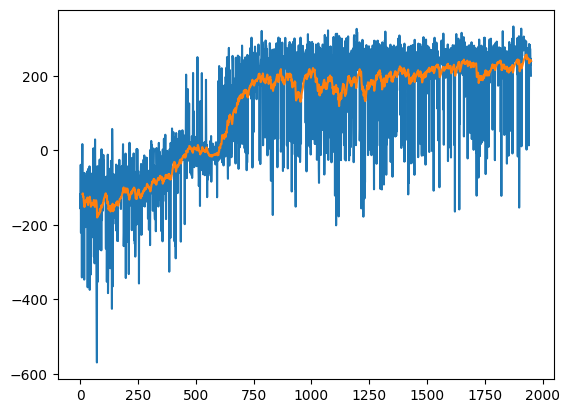

In [8]:
agent.train(2000)

In [19]:
agent.online_net.load_state_dict(torch.load('saved/lunarLander-DDQN-latest.pth'))

<All keys matched successfully>

In [20]:
agent.eval()

KeyboardInterrupt: 

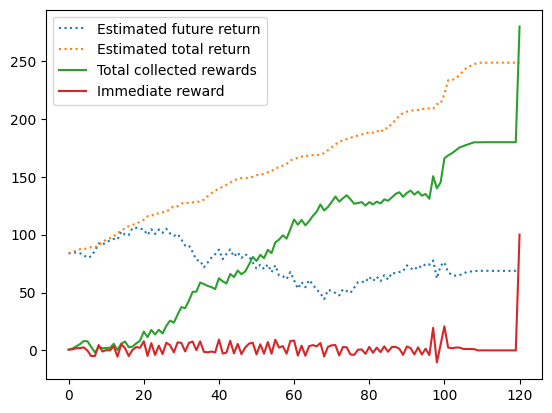

total rewards collected: 279.87829518120094


In [23]:
agent.play()

In [15]:
# save
torch.save(agent.online_net.state_dict(), 'saved/lunarLander-DDQN-latest.pth')

In [24]:
agent.env.close()